In [1]:
import pandas as pd
import numpy as np
%config inlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%run DLMO.ipynb
# plt.rcParams['font.family'] = 'Helvetica'


### Applying the new distribution calculation logic on the old pulled data ( running model on 3 data and taking average)

Distribution logic: \
  * the deficit reported for a date is the cumulative deficit on the PRIOR 7 days . If there is a catchup date in between the window then only the deficit which came AFTER the catchup will be considered.
  * The deficit reported for a night after a catchup night is zero

In [2]:
sleep_sample, activity_sample, phone_sample, user_id_mapping = importing_datasets()

Number of rows:  30963297
Unique users:  112928


In [3]:
import pandas as pd
import os.path
PredictedVsActual_all = pd.DataFrame()
for chosen_user in range(3386):
    fname = "/data/work/shared/s210142/datasets3/"+str(chosen_user)+".csv"
    if os.path.isfile(fname) == True:
        _df = pd.read_csv(fname)
        PredictedVsActual_all = pd.concat([PredictedVsActual_all,_df])
    else:
        print(chosen_user, " not found")

PredictedVsActual_all.drop(columns={'Unnamed: 0'},inplace=True)
PredictedVsActual_all['instance_id'] = PredictedVsActual_all['instance_id'] +1

0  not found
1  not found
198  not found
312  not found
431  not found
787  not found
804  not found
893  not found
991  not found
1714  not found
1750  not found
1835  not found
1858  not found
1873  not found
1927  not found
2237  not found
2298  not found
2364  not found
2421  not found
2502  not found
2510  not found
3078  not found
3210  not found
3279  not found
3385  not found


In [6]:
_skew = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()
_skew = _skew.reset_index()
_skew.rename(columns={'sleep_duration_round':'sleep_duration_skew'},inplace=True)

_avg = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').mean()
_avg = _avg.reset_index()
_avg.rename(columns={'sleep_duration_round':'sleep_duration_avg'},inplace=True)

_med = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').median()
_med = _med.reset_index()
_med.rename(columns = {'sleep_duration_round':'sleep_duration_median'},inplace=True)
_skew = _skew.merge(_med,how='left', left_on='user_id',right_on='user_id')
_skew['sleep_dur_median_bucket']= np.round(_skew['sleep_duration_median']*2)/2
_skew.sort_values(by='sleep_duration_skew',ascending=False, inplace=True)

_skew = _skew.merge(_avg, how='left',left_on = 'user_id',right_on='user_id')
_skew

,user_id,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg
0,1211,2.319075,6.73,6.5,6.937147
1,1182,1.966655,5.77,6.0,6.052583
2,2039,1.953479,5.32,5.5,5.736361
3,1901,1.937355,5.43,5.5,6.015566
4,67,1.808291,6.15,6.0,6.394125
...,...,...,...,...,...
3379,2070,-2.659640,6.90,7.0,6.827136
3380,733,-2.727773,8.57,8.5,8.444496
3381,2798,-2.840200,6.88,7.0,6.715773
3382,2567,-3.460372,7.72,7.5,7.602108


In [8]:
PredictedVsActual_all2 = PredictedVsActual_all.merge(_skew[['user_id',
                                                           'sleep_duration_median','sleep_duration_skew']],
                                                    how='left', left_on='user_id',
                                                    right_on = 'user_id')
PredictedVsActual_all2.head()

,sleep_start_shift,start_time_num_round,EstimatedSleepOnset,MinBtwnActualPred,sleep_duration_round,instance_id,user_id,sleep_duration_median,sleep_duration_skew
0,2017-03-12,24.75,24.05,42.0,7.58,1.0,2.0,6.97,-0.480549
1,2017-03-13,25.00,24.05,57.0,6.90,1.0,2.0,6.97,-0.480549
2,2017-03-14,25.50,24.30,72.0,6.72,1.0,2.0,6.97,-0.480549
3,2017-03-15,24.75,24.55,12.0,7.57,1.0,2.0,6.97,-0.480549
4,2017-03-16,25.00,24.05,57.0,7.13,1.0,2.0,6.97,-0.480549


In [9]:
PredictedVsActual_all2['lag_instance_id'] = PredictedVsActual_all2['instance_id'].shift(1) #changed from -1
PredictedVsActual_all2['lag_user_id'] = PredictedVsActual_all2['user_id'].shift(1) #changed from -1

conditions = [
    ((PredictedVsActual_all2['instance_id']-PredictedVsActual_all2['lag_instance_id']) == 0) &
    (PredictedVsActual_all2['lag_user_id'] == PredictedVsActual_all2['user_id'])] # change from ==1,switched around vars in subtraction
choices = [1]
PredictedVsActual_all2['continuous_instance'] = np.select(conditions,choices)

s = PredictedVsActual_all2['continuous_instance'].eq(True)
PredictedVsActual_all2['count'] = (PredictedVsActual_all2.groupby(['user_id',s.ne(s.shift()).cumsum()])
                         .cumcount()
                         .add(1)
                        )
PredictedVsActual_all2['count']= np.where(PredictedVsActual_all2['continuous_instance'] ==1,
                                        PredictedVsActual_all2['count']+1, PredictedVsActual_all2['count'])
PredictedVsActual_all2['user_instance_date'] = PredictedVsActual_all2['user_id'].astype(str)+'-' + \
PredictedVsActual_all2['instance_id'].astype(str)+'-'+PredictedVsActual_all2['sleep_start_shift'].astype(str)

PredictedVsActual_all2[['user_id','sleep_start_shift','instance_id','MinBtwnActualPred',
                       'count','continuous_instance']].iloc[91:100]

,user_id,sleep_start_shift,instance_id,MinBtwnActualPred,count,continuous_instance
91,2.0,2017-10-08,4.0,237.0,8,1
92,2.0,2017-10-09,4.0,-3.0,9,1
93,2.0,2017-10-10,4.0,-18.0,10,1
94,2.0,2017-10-11,4.0,42.0,11,1
95,2.0,2017-10-12,4.0,72.0,12,1
96,2.0,2017-10-13,4.0,57.0,13,1
97,2.0,2017-10-14,4.0,57.0,14,1
98,2.0,2017-10-15,4.0,72.0,15,1
99,2.0,2017-10-16,4.0,-18.0,16,1


In [53]:
import scipy.stats  as stats
window_size_arr = [10,15,20,25,30]
c_arr = [1,1.5,2,2.5]
for w in window_size_arr:
    for c in c_arr:
        PredictedVsActual_all2['catchup_sleep_length'] = np.round(PredictedVsActual_all2['sleep_duration_median']+c,2)
        PredictedVsActual_all2['catchup_flag'] = np.where(PredictedVsActual_all2['sleep_duration_round'] >= 
                                                 PredictedVsActual_all2['catchup_sleep_length'],1,0)


        catchup_array = []
        z =1
        while z <= 1000:
            catchup_instances = PredictedVsActual_all2[(PredictedVsActual_all2['catchup_flag']==1) &
                                              (PredictedVsActual_all2['sleep_duration_skew'] > 0.5) &
                                              (PredictedVsActual_all2['count'] >=w+1)]['user_instance_date']
            s = catchup_instances.sample(n=1)
            s = s.iloc[0]
            _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
            get_user = _temp['user_id'].values[0]
            get_instance = _temp['instance_id'].values[0]
            get_catchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

            _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                           (PredictedVsActual_all2['instance_id'] == get_instance) &
                                           (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_catchup_date)].reset_index()
    
            prev_date = get_catchup_date-pd.to_timedelta(1,unit='d')
            if (_temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0):
                _total = 0
                j = 1
                while j <= w:
                    prev_date = get_catchup_date-pd.to_timedelta(j,unit='d')
                    if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                        _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                              prev_date]['MinBtwnActualPred'].values[0]
                    else:
                        break
                    j+=1
                if abs(_total) <2000:
                    catchup_array.append([get_user, get_instance, get_catchup_date, _total])
                    z+=1
#                     if z%100 == 0:
#                         print("z: ",z," user: ", get_user, " get_instance: ",get_instance," get_catchup_date: ", get_catchup_date, " deficit: ", _total)
        
        catchup_array_df = pd.DataFrame(catchup_array)
        catchup_array_df.columns= ['user','instance','catchup_date','total']
        

        noncatchup_array = []
        z =0
        while z < 1000:
            noncatchup_instances = PredictedVsActual_all2[(PredictedVsActual_all2['catchup_flag']==0) &
                                                     (PredictedVsActual_all2['sleep_duration_skew'] > 0.5) &
                                                  (PredictedVsActual_all2['count'] >=w+1)]['user_instance_date']
            s = noncatchup_instances.sample(n=1)
            s = s.iloc[0]
            _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
            get_user = _temp['user_id'].values[0]
            get_instance = _temp['instance_id'].values[0]
            get_noncatchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

            _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                           (PredictedVsActual_all2['instance_id'] == get_instance) &
                                           (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_noncatchup_date)].reset_index()
            _total = 0
            j = 1
            while j <= w:
                prev_date = get_noncatchup_date-pd.to_timedelta(j,unit='d')

                if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                    _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                          prev_date]['MinBtwnActualPred'].values[0]

                else:
                    break
                j+=1
            if abs(_total) <2000:
                noncatchup_array.append([get_user, get_instance, get_noncatchup_date, _total])
                z+=1
#             if z%100 == 0:
#                 print("z: ",z," user: ", get_user, " get_instance: ",get_instance," get_noncatchup_date: ", get_noncatchup_date, " deficit: ", _total)

        noncatchup_array_df = pd.DataFrame(noncatchup_array)
        noncatchup_array_df.columns= ['user','instance','noncatchup_date','total']


        print("w: ",w," c: ",c,"catchup mean: ",np.round(np.mean(list(catchup_array_df['total'])),3), \
        "noncatchup mean: ",np.round(np.mean(list(noncatchup_array_df['total'])),3), \
              "catchup median: ",np.round(np.median(list(catchup_array_df['total'])),3), \
        "noncatchup median: ",np.round(np.median(list(noncatchup_array_df['total'])),3), \
         "test stat: ",np.round(stats.ttest_ind(a=catchup_array_df['total'],b=noncatchup_array_df['total'],equal_var=False)[0],3), \
              " pvalue: ",np.round(stats.ttest_ind(a=catchup_array_df['total'],b=noncatchup_array_df['total'],equal_var=False)[1],7)
             )


#         print("----------------------two sample t-test------------------------")
        

#         stats.ttest_ind(a=catchup_array_df['total'],b=noncatchup_array_df['total'],equal_var=False)

w:  10  c:  1 catchup mean:  398.022 noncatchup mean:  278.466 catchup median:  289.5 noncatchup median:  156.0 test stat:  7.015  pvalue:  0.0
w:  10  c:  1.5 catchup mean:  480.033 noncatchup mean:  367.503 catchup median:  375.0 noncatchup median:  228.0 test stat:  6.002  pvalue:  0.0
w:  10  c:  2 catchup mean:  495.42 noncatchup mean:  487.41 catchup median:  387.0 noncatchup median:  358.5 test stat:  0.39  pvalue:  0.6966952
w:  10  c:  2.5 catchup mean:  580.836 noncatchup mean:  566.565 catchup median:  483.0 noncatchup median:  487.5 test stat:  0.652  pvalue:  0.5145525
w:  15  c:  1 catchup mean:  399.972 noncatchup mean:  305.844 catchup median:  288.0 noncatchup median:  162.0 test stat:  5.152  pvalue:  3e-07
w:  15  c:  1.5 catchup mean:  471.24 noncatchup mean:  371.001 catchup median:  360.0 noncatchup median:  222.0 test stat:  5.157  pvalue:  3e-07
w:  15  c:  2 catchup mean:  554.79 noncatchup mean:  539.484 catchup median:  429.0 noncatchup median:  357.0 test st

In [ ]:
## 

In [57]:
w = 5
_less_ne0_5_array = []
z =1
while z <= 1000:
    _instances = PredictedVsActual_all2[(PredictedVsActual_all2['sleep_duration_skew'] < -0.5) &
                                              (PredictedVsActual_all2['count'] >=w+1)]['user_instance_date']
    s = _instances.sample(n=1)
    s = s.iloc[0]
    _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
    get_user = _temp['user_id'].values[0]
    get_instance = _temp['instance_id'].values[0]
    get_catchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

    _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                   (PredictedVsActual_all2['instance_id'] == get_instance) &
                                   (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_catchup_date)].reset_index()
    
    prev_date = get_catchup_date-pd.to_timedelta(1,unit='d')
    if (_temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0):
        _total = 0
        j = 1
        while j <= w:
            prev_date = get_catchup_date-pd.to_timedelta(j,unit='d')
            if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                      prev_date]['MinBtwnActualPred'].values[0]
            else:
                break
            j+=1
        _less_ne0_5_array.append([get_user, get_instance, get_catchup_date, _total])
    z+=1
    if z%100 == 0:
        print("user: ",get_user, "total: ",_total)
        
_less_ne0_5_array_df = pd.DataFrame(_less_ne0_5_array)
_less_ne0_5_array_df.columns= ['user','instance','catchup_date','total']

user:  2556.0 total:  -330.0
user:  2927.0 total:  255.0
user:  1385.0 total:  360.0
user:  1820.0 total:  480.0
user:  2256.0 total:  240.0
user:  2410.0 total:  -135.0
user:  59.0 total:  420.0
user:  1548.0 total:  690.0
user:  2918.0 total:  90.0
user:  1876.0 total:  -150.0


In [60]:
w = 5
_btwn_0_5_0_5_array = []
z =1
while z <= 1000:
    _instances = PredictedVsActual_all2[(PredictedVsActual_all2['sleep_duration_skew'].between(-0.5,0.5)) &
                                              (PredictedVsActual_all2['count'] >=w+1)]['user_instance_date']
    s = _instances.sample(n=1)
    s = s.iloc[0]
    _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
    get_user = _temp['user_id'].values[0]
    get_instance = _temp['instance_id'].values[0]
    get_catchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

    _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                   (PredictedVsActual_all2['instance_id'] == get_instance) &
                                   (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_catchup_date)].reset_index()
    
    prev_date = get_catchup_date-pd.to_timedelta(1,unit='d')
    if (_temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0):
        _total = 0
        j = 1
        while j <= w:
            prev_date = get_catchup_date-pd.to_timedelta(j,unit='d')
            if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                      prev_date]['MinBtwnActualPred'].values[0]
            else:
                break
            j+=1
        _btwn_0_5_0_5_array.append([get_user, get_instance, get_catchup_date, _total])
    z+=1
    if z%100 == 0:
        print("user: ",get_user, "total: ",_total)
        
_btwn_0_5_0_5_array_df = pd.DataFrame(_btwn_0_5_0_5_array)
_btwn_0_5_0_5_array_df.columns= ['user','instance','catchup_date','total']
                                         

user:  2926.0 total:  315.0
user:  1582.0 total:  435.0
user:  1688.0 total:  135.0
user:  2046.0 total:  270.0
user:  513.0 total:  615.0
user:  1432.0 total:  351.0
user:  1284.0 total:  -60.0
user:  2666.0 total:  210.0
user:  939.0 total:  225.0
user:  16.0 total:  0.0


In [61]:
w = 5
_ge_0_5_array = []
z =1
while z <= 1000:
    _instances = PredictedVsActual_all2[(PredictedVsActual_all2['sleep_duration_skew'] >= 0.5) &
                                              (PredictedVsActual_all2['count'] >=w+1)]['user_instance_date']
    s = _instances.sample(n=1)
    s = s.iloc[0]
    _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
    get_user = _temp['user_id'].values[0]
    get_instance = _temp['instance_id'].values[0]
    get_catchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

    _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                   (PredictedVsActual_all2['instance_id'] == get_instance) &
                                   (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_catchup_date)].reset_index()
    
    prev_date = get_catchup_date-pd.to_timedelta(1,unit='d')
    if (_temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0):
        _total = 0
        j = 1
        while j <= w:
            prev_date = get_catchup_date-pd.to_timedelta(j,unit='d')
            if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                      prev_date]['MinBtwnActualPred'].values[0]
            else:
                break
            j+=1
        _ge_0_5_array.append([get_user, get_instance, get_catchup_date, _total])
    z+=1
    if z%100 == 0:
        print("user: ",get_user, "total: ",_total)
        
_ge_0_5_array_df = pd.DataFrame(_ge_0_5_array)
_ge_0_5_array_df.columns= ['user','instance','catchup_date','total']
                                         

user:  1395.0 total:  6.0
user:  730.0 total:  228.0
user:  2500.0 total:  660.0
user:  383.0 total:  300.0
user:  897.0 total:  480.0
user:  279.0 total:  330.0
user:  709.0 total:  135.0
user:  898.0 total:  660.0
user:  927.0 total:  57.0
user:  2575.0 total:  -63.0


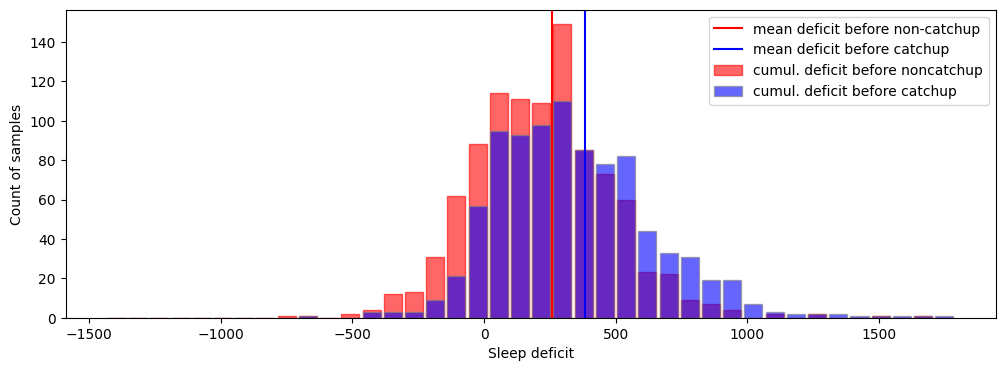

printing means -- skew < -0.5 vs skew > 0.5
258.64807302231236
382.4585635359116
----------------------two sample t-test------------------------


Ttest_indResult(statistic=-9.504241454377768, pvalue=6.138523428863588e-21)

In [69]:
bins = 40
both_arr = list(_less_ne0_5_array_df['total'])+list(_btwn_0_5_0_5_array_df['total'])+ \
list(_ge_0_5_array_df['total'])
'''getting the bins'''
_counts_le0_5, _bins_le0_5 = np.histogram(list(_less_ne0_5_array_df['total']), 
                                              range = (np.min(both_arr),np.max(both_arr)),bins=bins)
_counts_btwn_0_0_0_5, _bins_btwn_0_0_0_5 = np.histogram(list(_btwn_0_5_0_5_array_df['total']), 
                                              range = (np.min(both_arr),np.max(both_arr)),bins=bins)
_counts_ge0_5, _bins_ge0_5 = np.histogram(list(_ge_0_5_array_df['total']), 
                                              range = (np.min(both_arr),np.max(both_arr)),bins=bins)

bin_center = []
for i in range(len(_bins_btwn_0_0_0_5)-1):
        bin_center.append(np.round((_bins_btwn_0_0_0_5[i]+_bins_btwn_0_0_0_5[i+1])/2,2))
left_edges = _bins_btwn_0_0_0_5[:-1]

width = 0.85*(left_edges[1]-left_edges[0])
plt.figure(figsize=(12,4))
# plt.xlim(-500,500)
plt.xlabel("Sleep deficit")
plt.ylabel("Count of samples")
plt.bar(left_edges, _counts_le0_5, align='center',edgecolor='red',color='red',width=width,alpha=0.6, label='cumul. deficit before noncatchup')
# plt.bar(left_edges, _counts_btwn_0_0_0_5,align='center',edgecolor='grey', color='yellow',width=width,alpha=0.6, label='cumul. deficit before catchup')
plt.bar(left_edges, _counts_ge0_5,align='center',edgecolor='grey', color='blue',width=width,alpha=0.6, label='cumul. deficit before catchup')



plt.axvline(x=np.mean(list(_less_ne0_5_array_df['total'])),color='red', label = 'mean deficit before non-catchup')
# plt.axvline(x=np.mean(list(_btwn_0_5_0_5_array_df['total'])),color='yellow', label = 'mean deficit before catchup')
plt.axvline(x=np.mean(list(_ge_0_5_array_df['total'])),color='blue', label = 'mean deficit before catchup')



plt.legend()
plt.show()

print("printing means -- skew < -0.5 vs skew > 0.5")
print(np.mean(list(_less_ne0_5_array_df['total'])))
print(np.mean(list(_ge_0_5_array_df['total'])))

# print("printing medians -- noncatchup vs catchup")
# print("non catchup: ",np.median(list(noncatchup_array_df['total'])))
# print("catchup: ",np.median(list(catchup_array_df['total'])))

print("----------------------two sample t-test------------------------")
import scipy.stats  as stats

stats.ttest_ind(a=_less_ne0_5_array_df['total'],b=_ge_0_5_array_df['total'],equal_var=False)


### catchup instances

In [41]:
PredictedVsActual_all2['catchup_sleep_length'] = np.round(PredictedVsActual_all2['sleep_duration_median']+1,2)
PredictedVsActual_all2['catchup_flag'] = np.where(PredictedVsActual_all2['sleep_duration_round'] >= 
                                                 PredictedVsActual_all2['catchup_sleep_length'],1,0)

window_size = 5
catchup_array = []
z =1
while z <= 1000:
    catchup_instances = PredictedVsActual_all2[(PredictedVsActual_all2['catchup_flag']==1) &
                                              (PredictedVsActual_all2['sleep_duration_skew'] > 0.5) &
                                              (PredictedVsActual_all2['count'] >=window_size+1)]['user_instance_date']
    s = catchup_instances.sample(n=1)
    s = s.iloc[0]
    _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
    get_user = _temp['user_id'].values[0]
    get_instance = _temp['instance_id'].values[0]
    get_catchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])
#     get_window_date = get_catchup_date-pd.to_timedelta(window_size,unit='d')
    _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                  (PredictedVsActual_all2['instance_id'] == get_instance) &
        (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_catchup_date)].reset_index()
#     print("temp size: ", len(_temp), " catchupdate: ", get_catchup_date)
    
    prev_date = get_catchup_date-pd.to_timedelta(1,unit='d')
    if (_temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0):
        _total = 0
        j = 1
        while j <= window_size:
            prev_date = get_catchup_date-pd.to_timedelta(j,unit='d')
            if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                          prev_date]['MinBtwnActualPred'].values[0]
    #             print("total: ",_total)
            else:
                break
            j+=1
        if abs(_total) <2000:
            catchup_array.append([get_user, get_instance, get_catchup_date, _total])
            z+=1
            if z%100 == 0:
                print("z: ",z," user: ", get_user, " get_instance: ",get_instance," get_catchup_date: ", get_catchup_date, " deficit: ", _total)
        
catchup_array_df = pd.DataFrame(catchup_array)
catchup_array_df.columns= ['user','instance','catchup_date','total']
        

z:  100  user:  1893.0  get_instance:  8.0  get_catchup_date:  2018-06-14 00:00:00  deficit:  117.0
z:  200  user:  40.0  get_instance:  3.0  get_catchup_date:  2016-06-02 00:00:00  deficit:  324.0
z:  300  user:  2586.0  get_instance:  7.0  get_catchup_date:  2018-10-30 00:00:00  deficit:  216.0
z:  400  user:  711.0  get_instance:  1.0  get_catchup_date:  2016-04-29 00:00:00  deficit:  390.0
z:  500  user:  1222.0  get_instance:  7.0  get_catchup_date:  2016-11-12 00:00:00  deficit:  375.0
z:  600  user:  721.0  get_instance:  2.0  get_catchup_date:  2016-04-09 00:00:00  deficit:  165.0
z:  700  user:  1380.0  get_instance:  4.0  get_catchup_date:  2016-12-02 00:00:00  deficit:  525.0
z:  800  user:  1893.0  get_instance:  6.0  get_catchup_date:  2017-11-10 00:00:00  deficit:  30.0
z:  900  user:  3382.0  get_instance:  11.0  get_catchup_date:  2019-02-20 00:00:00  deficit:  -9.0
z:  1000  user:  2211.0  get_instance:  7.0  get_catchup_date:  2018-08-04 00:00:00  deficit:  570.0


### non catchup instances

In [42]:
window_size = 5
noncatchup_array = []
z =0
while z < 1000:
    noncatchup_instances = PredictedVsActual_all2[(PredictedVsActual_all2['catchup_flag']==0) &
                                                 (PredictedVsActual_all2['sleep_duration_skew'] > 0.5) &
                                              (PredictedVsActual_all2['count'] >=window_size+1)]['user_instance_date']
    s = noncatchup_instances.sample(n=1)
    s = s.iloc[0]
    _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
    get_user = _temp['user_id'].values[0]
    get_instance = _temp['instance_id'].values[0]
    get_noncatchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

    _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                  (PredictedVsActual_all2['instance_id'] == get_instance) &
        (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_noncatchup_date)].reset_index()
#     print("user: ", get_user, "instance: ", get_instance,"temp size: ", len(_temp), " catchupdate: ", get_noncatchup_date)
    _total = 0
    j = 1
    while j <= window_size:
        prev_date = get_noncatchup_date-pd.to_timedelta(j,unit='d')
#         print("prev date: ", prev_date)
        if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
            _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                  prev_date]['MinBtwnActualPred'].values[0]
#             print("total: ",_total)
        else:
            break
        j+=1
    if abs(_total) <2000:
        noncatchup_array.append([get_user, get_instance, get_noncatchup_date, _total])
        z+=1
        if z%100 == 0:
            print("z: ",z," user: ", get_user, " get_instance: ",get_instance," get_noncatchup_date: ", get_noncatchup_date, " deficit: ", _total)
        
noncatchup_array_df = pd.DataFrame(noncatchup_array)
noncatchup_array_df.columns= ['user','instance','noncatchup_date','total']

z:  100  user:  1273.0  get_instance:  8.0  get_noncatchup_date:  2017-02-13 00:00:00  deficit:  132.0
z:  200  user:  40.0  get_instance:  3.0  get_noncatchup_date:  2016-07-02 00:00:00  deficit:  207.0
z:  300  user:  1489.0  get_instance:  5.0  get_noncatchup_date:  2017-01-18 00:00:00  deficit:  171.0
z:  400  user:  2741.0  get_instance:  3.0  get_noncatchup_date:  2017-06-27 00:00:00  deficit:  9.0
z:  500  user:  2741.0  get_instance:  3.0  get_noncatchup_date:  2017-06-14 00:00:00  deficit:  96.0
z:  600  user:  3117.0  get_instance:  1.0  get_noncatchup_date:  2017-09-24 00:00:00  deficit:  0
z:  700  user:  1556.0  get_instance:  6.0  get_noncatchup_date:  2019-03-13 00:00:00  deficit:  21.0
z:  800  user:  2896.0  get_instance:  3.0  get_noncatchup_date:  2016-06-05 00:00:00  deficit:  657.0
z:  900  user:  1825.0  get_instance:  2.0  get_noncatchup_date:  2016-11-22 00:00:00  deficit:  945.0
z:  1000  user:  2294.0  get_instance:  6.0  get_noncatchup_date:  2017-09-20 00:00

In [328]:
PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == 1090) &(PredictedVsActual_all2['instance_id'] == 7) 
                       & (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) 
                       <= pd.to_datetime('2019-01-22'))][['sleep_start_shift','start_time_num_round',
                                                          'EstimatedSleepOnset',
                                                          'instance_id','catchup_flag',
                                                 'MinBtwnActualPred']].iloc[-8:]


,sleep_start_shift,start_time_num_round,EstimatedSleepOnset,instance_id,catchup_flag,MinBtwnActualPred
283457,2019-01-15,22.00,20.30,7.0,0,102.0
283458,2019-01-16,22.75,20.05,7.0,0,162.0
283459,2019-01-17,23.25,20.05,7.0,0,192.0
283460,2019-01-18,22.00,20.05,7.0,0,117.0
283461,2019-01-19,23.75,20.05,7.0,0,222.0
283462,2019-01-20,22.00,20.55,7.0,0,87.0
283463,2019-01-21,22.75,20.55,7.0,0,132.0
283464,2019-01-22,22.00,20.30,7.0,0,102.0


In [54]:
132+87+222+117+192

750

## Distribution plot

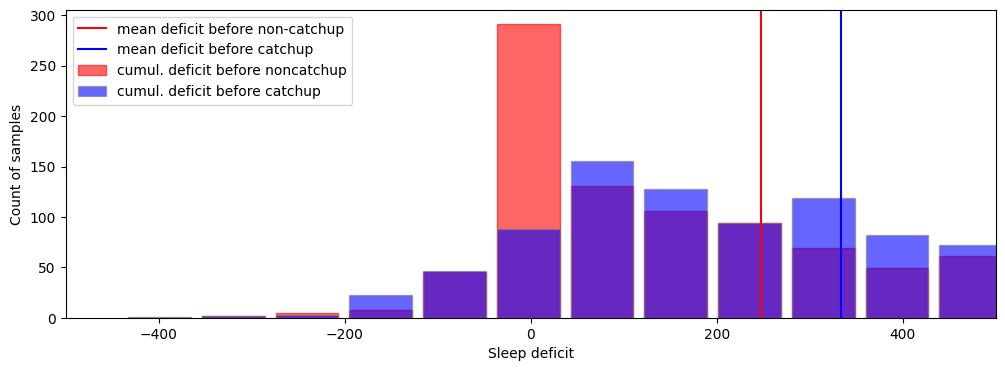

printing means -- noncatchup vs catchup
247.914
333.768
printing medians -- noncatchup vs catchup
non catchup:  168.0
catchup:  279.0
----------------------two sample t-test------------------------


Ttest_indResult(statistic=6.645685432543454, pvalue=3.883644197097151e-11)

In [44]:
bins = 30
both_arr = list(catchup_array_df['total'])+list(noncatchup_array_df['total'])
'''getting the bins'''
_counts_catchup, _bins_catchup = np.histogram(list(catchup_array_df['total']), 
                                              range = (np.min(both_arr),np.max(both_arr)),bins=bins)
_counts_noncatchup, _bins_noncatchup = np.histogram(list(noncatchup_array_df['total']), 
                                              range = (np.min(both_arr),np.max(both_arr)),bins=bins)

bin_center = []
for i in range(len(_bins_catchup)-1):
        bin_center.append(np.round((_bins_catchup[i]+_bins_catchup[i+1])/2,2))
left_edges = _bins_noncatchup[:-1]

width = 0.85*(left_edges[1]-left_edges[0])
plt.figure(figsize=(12,4))
plt.xlim(-500,500)
plt.xlabel("Sleep deficit")
plt.ylabel("Count of samples")
plt.bar(left_edges, _counts_noncatchup, align='center',edgecolor='red',color='red',width=width,alpha=0.6, label='cumul. deficit before noncatchup')
plt.bar(left_edges, _counts_catchup,align='center',edgecolor='grey', color='blue',width=width,alpha=0.6, label='cumul. deficit before catchup')

plt.axvline(x=np.mean(list(noncatchup_array_df['total'])),color='red', label = 'mean deficit before non-catchup')
plt.axvline(x=np.mean(list(catchup_array_df['total'])),color='blue', label = 'mean deficit before catchup')

# plt.axvline(x=np.median(list(noncatchup_array)),color='red',linestyle='dotted', label = 'median surplus before non-catchup')
# plt.axvline(x=np.median(list(catchup_array)),color='blue', linestyle= 'dotted', label = 'median surplus before catchup')


plt.legend()
plt.show()

print("printing means -- noncatchup vs catchup")
print(np.mean(list(noncatchup_array_df['total'])))
print(np.mean(list(catchup_array_df['total'])))

print("printing medians -- noncatchup vs catchup")
print("non catchup: ",np.median(list(noncatchup_array_df['total'])))
print("catchup: ",np.median(list(catchup_array_df['total'])))

print("----------------------two sample t-test------------------------")
import scipy.stats  as stats

stats.ttest_ind(a=catchup_array_df['total'],b=noncatchup_array_df['total'],equal_var=False)

## Sample visualisations

In [24]:
set_user =1104
set_instance = 9

In [25]:
PredictedVsActual_all2['catchup_sleep_length'] = np.round(PredictedVsActual_all2['sleep_duration_median']+1,2)
PredictedVsActual_all2['catchup_flag'] = np.where(PredictedVsActual_all2['sleep_duration_round'] >= 
                                                 PredictedVsActual_all2['catchup_sleep_length'],1,0)
for_viz = PredictedVsActual_all2[(PredictedVsActual_all2['user_id']==set_user) & 
                                  (PredictedVsActual_all2['instance_id']==set_instance)].reset_index(drop=True)
for_viz['weekend'] = np.where(pd.to_datetime(for_viz['sleep_start_shift']).dt.dayofweek.isin([4,5]),1,0)
Weekend = for_viz['weekend']
print(len(for_viz), len(Weekend))

136 136


In [26]:
firstdate = np.min(for_viz['sleep_start_shift'])
lastdate = np.max(for_viz['sleep_start_shift'])
print(firstdate, lastdate)

2017-08-21 2018-01-03


In [27]:
rollup_phone = phone_sample[(phone_sample['user_id']==set_user) & 
             (phone_sample['day_label_dt'].between(pd.to_datetime(firstdate), pd.to_datetime(lastdate))) &
                     (phone_sample['start_time_num_round']>=15)]
rollup_phone['hour'] = rollup_phone['start_time_num_round'].astype(int)
rollup_phone = rollup_phone[['day_label_dt','hour','duration']].groupby(['day_label_dt','hour']).sum().reset_index()
rollup_phone = rollup_phone[['day_label_dt','hour']].groupby(['day_label_dt']).max().reset_index()

# activity
rollup_activity = activity_sample[(activity_sample['user_id']==set_user) & 
             (activity_sample['day_label_dt'].between(pd.to_datetime(firstdate), pd.to_datetime(lastdate))) &
                     (activity_sample['start_time_num_round']>=15)]
rollup_activity['hour'] = rollup_activity['start_time_num_round'].astype(int)
rollup_activity = rollup_activity[['day_label_dt','hour','steps']].groupby(['day_label_dt','hour']).sum().reset_index()
rollup_activity = rollup_activity[['day_label_dt','hour']].groupby(['day_label_dt']).max().reset_index()


rollup_combined = rollup_activity.merge(rollup_phone,how='outer',left_on = 'day_label_dt',
                                        right_on='day_label_dt')


rollup_combined['hour']= np.max(rollup_combined[['hour_x','hour_y']],axis=1)

print(len(rollup_combined))
rollup_combined.head(n=1)


/tmp/ipykernel_3633206/2800204512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rollup_phone['hour'] = rollup_phone['start_time_num_round'].astype(int)


136


/tmp/ipykernel_3633206/2800204512.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rollup_activity['hour'] = rollup_activity['start_time_num_round'].astype(int)


,day_label_dt,hour_x,hour_y,hour
0,2017-08-21,22,23,23


In [28]:
window_size=5
def sawtooth(MinutesBetween,
            window_size,SleepingDates_ds):
    _net_deficit = []
    _net_deficit_date = []
    catchup_date = []
    date_list = list(SleepingDates_ds['sleep_start_shift'])
    MinsBtwn1 = [x if x is not None else 0 for x in MinutesBetween]
    for i in range(len(MinsBtwn1)-window_size):
        j = window_size
        _temp = 0
        while j > 0:
            if SleepingDates_ds['sleep_duration_round'].iloc[i+j-1] < SleepingDates_ds['catchup_sleep_length'].iloc[i+j-1]:
                _temp += MinsBtwn1[i+j-1]
            else:
                if (i+j-1 > window_size) & (SleepingDates_ds['sleep_start_shift'].iloc[i+j-1] not in catchup_date):
                    catchup_date.append(SleepingDates_ds['sleep_start_shift'].iloc[i+j-1])
#                 _temp = 0
                break
            j=j-1
#             print(i,i+j-1)
            
        _net_deficit.append(_temp)
        _net_deficit_date.append(date_list[i+window_size])
    deficit_dict = {_net_deficit_date[k]: _net_deficit[k] for k in range(len(_net_deficit_date))}
        
    return _net_deficit, _net_deficit_date, catchup_date, deficit_dict
MinutesBetweenPredictedAndActualSleep_phone_activity = list(for_viz['MinBtwnActualPred'])
net_deficit, net_dates, catchup_date,deficit_dict = sawtooth(MinutesBetweenPredictedAndActualSleep_phone_activity, 
                                  5, for_viz)
deficit_dict
catchup_deficits = []
for dates in catchup_date:
    catchup_deficits.append(deficit_dict[dates])

User id: 1104 skew: 1.565 median: 4.37 catchup: 5.37


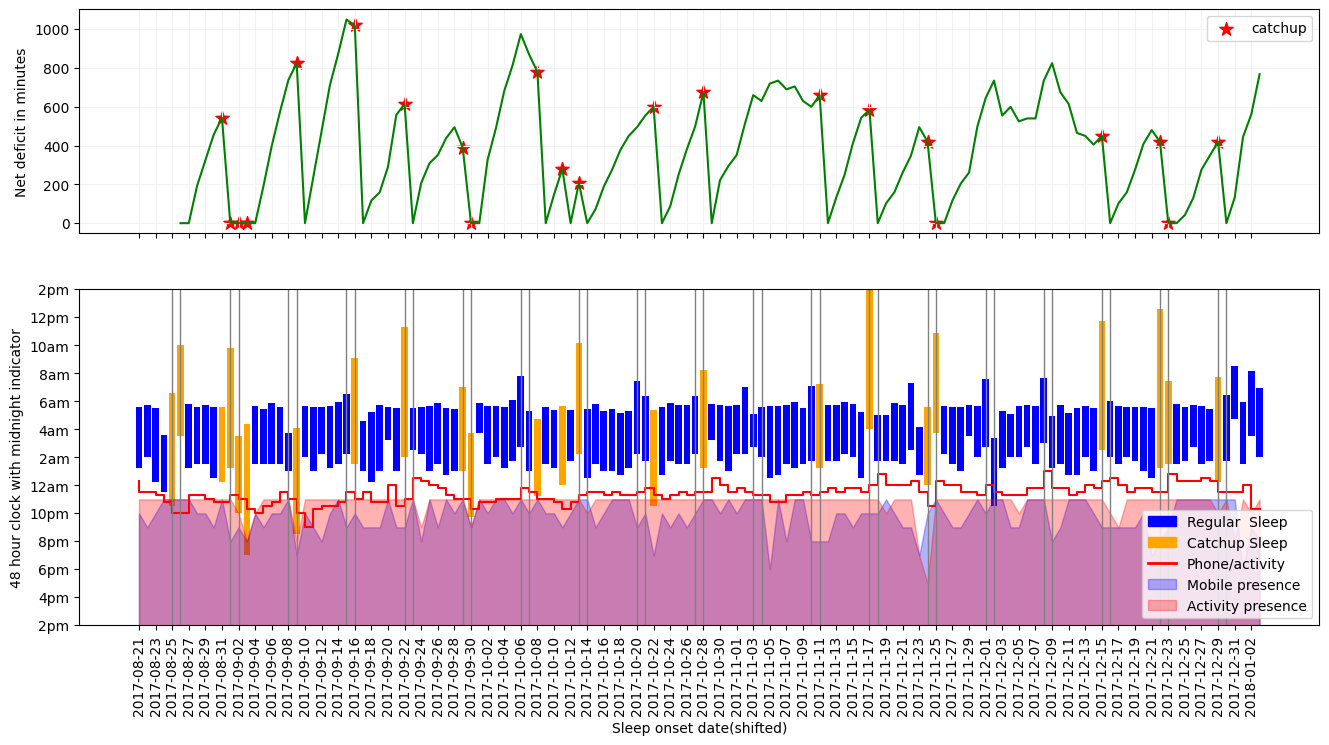

In [30]:
color_for_bars = []
SleepingDates = for_viz['sleep_start_shift']
fig, axs = plt.subplots(2,1,figsize=(16,8),sharex=True,height_ratios = {1,1.5})
axs= axs.flatten()

set_interval = 2
date_list2 = []
for s in SleepingDates:
    if list(SleepingDates).index(s)%set_interval == 0:
        date_list2.append(s) 
        
for i in range(len(for_viz)):
    if for_viz['catchup_flag'].iloc[i] == 1:
        color_for_bars.append("orange")
    else:
        color_for_bars.append("blue")   
        
axs[0].plot(pd.to_datetime(net_dates), net_deficit, color='green') 
axs[0].scatter(pd.to_datetime(catchup_date), catchup_deficits, marker = "*",color='red',s=100,label="catchup")
axs[0].grid(color='0.95')
axs[0].set_ylabel("Net deficit in minutes")
# _txt = str(window_size)+"-day cumulative deficit unless encountered catchup sleep (deficit set to 0)"
# axs[0].set_title(_txt)
axs[0].legend()
where_type = "pre"
axs[1].set_ylim(14,38)
axs[1].set_yticks(np.arange(14,40,2))
axs[1].set_yticklabels(['2pm','4pm','6pm','8pm','10pm','12am','2am','4am','6am','8am','10am','12pm','2pm'])
axs[1].bar(pd.to_datetime(for_viz['sleep_start_shift']),for_viz['start_time_num_round'],color='white')
axs[1].bar(pd.to_datetime(for_viz['sleep_start_shift']),for_viz['sleep_duration_round'],
        bottom = for_viz['start_time_num_round'],color=color_for_bars)
axs[1].step(pd.to_datetime(for_viz['sleep_start_shift']),for_viz['EstimatedSleepOnset'], 
         color='red', where=where_type, label = "Predicted sleep onset - Phone/Activity")


p = axs[1].fill_between(pd.to_datetime(rollup_combined['day_label_dt']), rollup_combined['hour_x'],
                        color='blue',alpha=0.3,label='mobile')
q = axs[1].fill_between(pd.to_datetime(rollup_combined['day_label_dt']), rollup_combined['hour_y'],
                        color = 'red',alpha=0.3,label='activity')

axs[1].set_xticks(date_list2)
axs[1].tick_params(axis='x',rotation=90)      
axs[1].set_xticklabels(date_list2)
axs[1].tick_params('x',rotation=90)
# axs[1].set_title(" Sleep times in 24 hour periods starting at 2pm")
axs[1].set_xlabel("Sleep onset date(shifted)")
axs[1].set_ylabel("48 hour clock with midnight indicator")


for i in range(len(Weekend)):
    if Weekend[i]== 1:
        axs[1].axvline(x=pd.to_datetime(for_viz['sleep_start_shift']).iloc[i],linewidth=1,color="grey") 

_txt = "User id: "+str(set_user)+" skew: "+str(np.round(for_viz['sleep_duration_skew'].iloc[0],3))+ \
" median: "+str(np.round(for_viz['sleep_duration_median'].iloc[0],3))+" catchup: "+ \
               str(np.round(for_viz['catchup_sleep_length'].iloc[0],3))


from matplotlib.patches import Patch
from matplotlib.lines import Line2D
blue_patch = Patch(color = 'blue',label = 'Regular  Sleep')
pink_patch = Patch(color = 'orange',label = 'Catchup Sleep')
mobile_patch = Patch(color = 'blue',alpha = 0.3,label = 'Mobile presence')
activity_patch = Patch(color = 'red',alpha = 0.3, label = 'Activity presence')
custom_legends = [blue_patch, pink_patch,Line2D([0],[0],color='red',lw=2,label='Phone/activity'),mobile_patch,
                 activity_patch]

plt.legend(handles = custom_legends,loc='lower right')
print(_txt)
# plt.figtext(0.33,0.92, _txt,fontsize=14)
plt.savefig("/file/out/antar/_user_1104_catchup_sawtooth.png",dpi=400)
plt.show() 


In [299]:
_skew[_skew['sleep_duration_skew'] < -1.5]
aa = PredictedVsActual_all2[PredictedVsActual_all2['sleep_duration_skew']< -1.5]['user_id'].unique()

## KS test at individual level

In [432]:
PredictedVsActual_all2['catchup_sleep_length'] = np.round(PredictedVsActual_all2['sleep_duration_median']+1,2)
PredictedVsActual_all2['catchup_flag'] = np.where(PredictedVsActual_all2['sleep_duration_round'] >= 
                                                 PredictedVsActual_all2['catchup_sleep_length'],1,0)
from scipy import stats
window_size = 7
# user_list = [1073]
user_list = np.array(_skew[_skew['sleep_duration_skew'] > 0.5]['user_id'])
print("count of users to be evaluated: ", len(user_list))
user_ks= []
for i in range(len(user_list)):
    user = user_list[i]
    catchup_instances = PredictedVsActual_all2[(PredictedVsActual_all2['catchup_flag']==1) &
                                              (PredictedVsActual_all2['user_id']==user) &
                                              (PredictedVsActual_all2['count'] >=window_size+1)]['user_instance_date']

    _output_catchup = []
    for _instance in catchup_instances:
#             print("catchup instance: ", _instance)
        _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==_instance].reset_index()
        get_user = user
        get_instance = _temp['instance_id'].values[0]
        get_catchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

        _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                       (PredictedVsActual_all2['instance_id'] == get_instance) &
                                       (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_catchup_date)].reset_index()


        prev_date = get_catchup_date-pd.to_timedelta(1,unit='d')
        if (_temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0): #not a catchup
            _total = 0
            j = 1
            while j <= window_size:
                prev_date = get_catchup_date-pd.to_timedelta(j,unit='d')
                if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                    _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                              prev_date]['MinBtwnActualPred'].values[0]

                else:
                    break
                j+=1
#                 print("appending: ",_total)
            _output_catchup.append(_total)

    store_catchup_count= len(_output_catchup)

# ''' Non catchup instances for the same user'''
    _output_noncatchup = []     
#     print("count of catchup instances: ",store_catchup_count)
    z = 0
    while z < store_catchup_count:
        noncatchup_instances = PredictedVsActual_all2[(PredictedVsActual_all2['catchup_flag']==0) &
                                                 (PredictedVsActual_all2['user_id'] == user) &
                                              (PredictedVsActual_all2['count'] >=window_size+1)]['user_instance_date']

        s = noncatchup_instances.sample(n=1)
        s = s.iloc[0]

        _temp = PredictedVsActual_all2[PredictedVsActual_all2['user_instance_date']==s].reset_index()
        get_user = user
        get_instance = _temp['instance_id'].values[0]
        get_noncatchup_date = pd.to_datetime(_temp['sleep_start_shift'].values[0])

        _temp = PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == get_user) &
                                  (PredictedVsActual_all2['instance_id'] == get_instance) &
        (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift']) <= get_noncatchup_date)].reset_index()
#             print("length of non catchup array: ", len(_temp), " for non catchup date: ",get_noncatchup_date)
        _total = 0
        j = 1
        while j <= window_size:
            prev_date = get_noncatchup_date-pd.to_timedelta(j,unit='d')
    #         print("prev date: ", prev_date)
            if _temp[pd.to_datetime(_temp['sleep_start_shift'])== prev_date]['catchup_flag'].values[0] == 0:
                _total = _total+_temp[pd.to_datetime(_temp['sleep_start_shift'])== 
                                      prev_date]['MinBtwnActualPred'].values[0]
    #             print("total: ",_total)
            else:
                break
            j+=1

        _output_noncatchup.append(_total)
        z+=1

    if len(_output_catchup) == len(_output_noncatchup) & len(_output_catchup) > 0:
        user_ks.append([user,stats.ks_2samp(_output_catchup, _output_noncatchup)[1]])
        print("id: ",i, " user: ",user, " KS: ",stats.ks_2samp(_output_catchup, _output_noncatchup)[1])

count of users to be evaluated:  584
id:  0  user:  1211  KS:  0.37272752790955144
id:  1  user:  1182  KS:  0.011604533614075598
id:  2  user:  2039  KS:  0.0057719930314983296
id:  3  user:  1901  KS:  1.0
id:  4  user:  67  KS:  0.6
id:  5  user:  415  KS:  0.35714285714285715
id:  6  user:  1073  KS:  0.00041352891306427824
id:  7  user:  760  KS:  0.3067583443758178
id:  8  user:  755  KS:  0.009223959448847003
id:  9  user:  1104  KS:  1.7753369827203675e-06
id:  10  user:  2896  KS:  0.09999999999999999
id:  11  user:  3276  KS:  6.34625811956265e-13
id:  12  user:  730  KS:  1.1159509154253002e-06
id:  13  user:  1153  KS:  0.12648770263254042
id:  14  user:  657  KS:  0.0019790709048350735
id:  15  user:  352  KS:  0.018400608756955844
id:  16  user:  2501  KS:  0.004445364034573936
id:  17  user:  3362  KS:  0.002112466385728937
id:  18  user:  1787  KS:  0.17318624413929476
id:  19  user:  297  KS:  0.002874834144183989
id:  20  user:  203  KS:  9.956910259720608e-05
id:  21

id:  181  user:  2528  KS:  0.06898879546934714
id:  182  user:  495  KS:  0.012071814151101576
id:  183  user:  247  KS:  0.14451472018143485
id:  184  user:  3226  KS:  0.0049505362451629726
id:  185  user:  1322  KS:  0.02860307028023343
id:  186  user:  1477  KS:  0.5721774392909802
id:  187  user:  3336  KS:  0.35714285714285715
id:  188  user:  2121  KS:  0.9992123531334729
id:  189  user:  1673  KS:  0.058268826492191214
id:  190  user:  1378  KS:  7.703934130918306e-06
id:  191  user:  975  KS:  0.8319696107963263
id:  192  user:  560  KS:  0.05902987790590428
id:  193  user:  2705  KS:  0.41752365281777043
id:  194  user:  1489  KS:  4.574202978839911e-05
id:  195  user:  416  KS:  0.08973505796946307
id:  196  user:  3203  KS:  6.0842532712237615e-06
id:  197  user:  613  KS:  1.0
id:  198  user:  2910  KS:  0.01430154804770646
id:  199  user:  1920  KS:  0.36743563987529626
id:  200  user:  792  KS:  7.115916975912639e-12
id:  201  user:  2537  KS:  0.007945718302533482
id: 

id:  357  user:  1487  KS:  1.0
id:  358  user:  1748  KS:  0.06447638786794979
id:  359  user:  1044  KS:  0.832587690946824
id:  360  user:  3363  KS:  0.15576025200619348
id:  361  user:  321  KS:  0.873015873015873
id:  362  user:  2101  KS:  0.025581879872371097
id:  363  user:  3300  KS:  0.11599640418778094
id:  364  user:  3220  KS:  0.38794224999131643
id:  365  user:  3174  KS:  0.21212121212121213
id:  366  user:  497  KS:  2.3617729712556523e-10
id:  367  user:  3157  KS:  0.1675692876756983
id:  368  user:  421  KS:  0.4754535018190584
id:  369  user:  672  KS:  0.00020990145960412908
id:  370  user:  399  KS:  0.0008323117333128456
id:  371  user:  479  KS:  0.0008010385362435816
id:  372  user:  21  KS:  0.42629346134549484
id:  373  user:  622  KS:  4.566483309802445e-06
id:  374  user:  3133  KS:  0.3234812170971206
id:  375  user:  2330  KS:  1.0
id:  376  user:  2856  KS:  0.7465280660458108
id:  377  user:  473  KS:  0.35170711641299873
id:  378  user:  3324  KS:  0

id:  534  user:  1363  KS:  0.0008995776840176799
id:  535  user:  2672  KS:  0.562189184580869
id:  536  user:  2575  KS:  0.1963120402389556
id:  537  user:  1320  KS:  0.0032406377456433077
id:  538  user:  1216  KS:  0.12648770263254042
id:  539  user:  2214  KS:  0.010912592320303841
id:  540  user:  1273  KS:  0.002834980581320342
id:  541  user:  545  KS:  0.002467567098321789
id:  542  user:  220  KS:  0.0004941794173795195
id:  543  user:  1554  KS:  0.30712304007383906
id:  544  user:  1268  KS:  0.4217817995595472
id:  545  user:  1380  KS:  0.8079631540901643
id:  546  user:  1693  KS:  0.005467427576534314
id:  547  user:  1173  KS:  0.020747520755971537
id:  548  user:  1136  KS:  0.024674332703421464
id:  549  user:  3060  KS:  0.16497269950224194
id:  550  user:  1032  KS:  3.800827929128319e-05
id:  551  user:  2077  KS:  0.00014242688813919193
id:  552  user:  2064  KS:  1.0
id:  553  user:  2546  KS:  0.479150364599281
id:  554  user:  2490  KS:  0.36497950870925666


In [414]:
np.sum(PredictedVsActual_all2[(PredictedVsActual_all2['user_id'] == 1073)]['catchup_flag'])

41

In [423]:
len(_output_catchup)

22

In [444]:
user_ks_df = pd.DataFrame(user_ks,columns=['user_id','p_value'])
user_ks_df.to_csv("/data/work/shared/s210142/datasets/user_ks_df.csv")

In [445]:
user_ks_df = user_ks_df.merge(_skew[['user_id','sleep_dur_median_bucket']],how='left',left_on='user_id',
                             right_on='user_id')
user_ks_df

,user_id,p_value,sleep_dur_median_bucket
0,1211,0.372728,6.5
1,1182,0.011605,6.0
2,2039,0.005772,5.5
3,1901,1.000000,5.5
4,67,0.600000,6.0
...,...,...,...
564,3165,0.001501,5.0
565,2853,0.474026,5.0
566,3016,0.153173,7.0
567,3377,0.001834,6.0


In [452]:
user_ks1 = user_ks_df[['sleep_dur_median_bucket','p_value']].groupby('sleep_dur_median_bucket').median()
user_ks1.T

sleep_dur_median_bucket,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0
p_value,0.050486,0.026749,0.013797,0.039426,0.037327,0.064476,0.044604,0.242565,0.36498,0.068989,0.708762


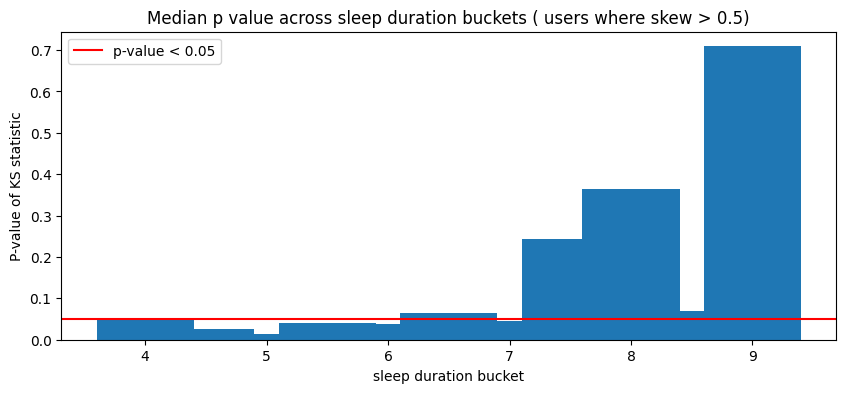

In [456]:
plt.figure(figsize = (10,4))
plt.bar(user_ks1.index, user_ks1['p_value'])
plt.axhline(y= 0.05,color= 'red',label= "p-value < 0.05")
plt.xlabel("sleep duration bucket")
plt.ylabel("P-value of KS statistic")
plt.title("Median p value across sleep duration buckets ( users where skew > 0.5)")
plt.legend()
plt.show()

In [481]:

PredictedVsActual_all2[(PredictedVsActual_all2['user_id']==40) &
                       (pd.to_datetime(PredictedVsActual_all2['sleep_start_shift'])== pd.to_datetime('2016-02-22'))]

,sleep_start_shift,start_time_num_round,EstimatedSleepOnset,MinBtwnActualPred,sleep_duration_round,instance_id,user_id,sleep_duration_median,sleep_duration_skew,lag_instance_id,lag_user_id,continuous_instance,count,user_instance_date,catchup_sleep_length,catchup_flag
10052,2016-02-22,22.0,24.05,-123.0,8.38,2.0,40.0,6.0,0.505221,2.0,40.0,1,23,40.0-2.0-2016-02-22,7.0,1


In [495]:
activity_sample[activity_sample['user_id']==40 &
(activity_sample['day_label_dt']>= pd.to_datetime('2016-01-01'))]
            
            

,day_label,start_time_num_round,steps,day_label_dt,user_id


In [489]:
activity_sample['day_label_dt']

0          2016-11-24
1          2017-08-12
2          2017-09-20
3          2017-10-19
4          2017-11-13
              ...    
48559843   2018-10-25
48559844   2018-11-13
48559845   2018-12-20
48559846   2018-12-22
48559847   2018-12-22
Name: day_label_dt, Length: 48559848, dtype: datetime64[ns]